## Create subset of data

In [11]:
import os, shutil, random
random.seed(42)

# Path to main dataset (patients are subfolders here)
main_dir = "dataset"

# Where we’ll store a smaller subset
subset_dir = "smaller_datset"
os.makedirs(os.path.join(subset_dir, "cancer"), exist_ok=True)
os.makedirs(os.path.join(subset_dir, "non-cancer"), exist_ok=True)

# Pick a few patient folders (adjust number as needed)
all_patients = os.listdir(main_dir)
selected_patients = random.sample(all_patients, 250)  # pick 15 random patients
print("Using patients:", selected_patients)

# Copy images into cancer/non-cancer based on filename
for patient in selected_patients:
    patient_path = os.path.join(main_dir, patient)
    
    for root, dirs, files in os.walk(patient_path):
        for file in files[:200]:  # limit per folder so it stays small
            src_path = os.path.join(root, file)
            if "class0" in file.lower():   # non-cancer
                shutil.copy(src_path, os.path.join(subset_dir, "non-cancer"))
            elif "class1" in file.lower(): # cancer
                shutil.copy(src_path, os.path.join(subset_dir, "cancer"))


Using patients: ['14191', '12933', '12929', '9175', '9266', '12907', '10254', '16570', '12948', '12821', '8913', '13617', '10259', '13023', '16014', '10293', '15471', '12242', '9078', '10255', '10303', '12955', '12749', '14210', '9125', '12886', '14190', '10302', '12935', '8957', '12900', '9036', '12930', '15634', '15472', '12879', '9073', '10261', '13020', '10307', '9123', '9083', '12901', '12896', '12873', '8863', '12947', '14321', '12934', '12867', '8950', '9321', '10282', '10308', '12954', '15633', '13916', '13459', '9346', '10258', '10301', '9257', '14189', '9225', '10264', '13689', '12882', '10292', '10260', '9177', '12898', '16533', '13458', '10286', '13018', '15515', '9344', '10304', '10288', '9076', '13687', '10290', '9022', '13691', '10273', '12819', '13021', '14211', '13461', '9173', '10299', '12931', '13024', '15839', '12823', '15632', '8951', '9267', '9081', '12817', '9228', '15840', '16568', '9126', '12824', '14209', '9250', '12892', '12893', '12894', '12895', '16569', '9

## Model version 1: VGG16 with Imagenet weights
freezed base model

Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.
Epoch 1/20
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 408s 188ms/step - accuracy: 0.7864 - loss: 0.4727 - val_accuracy: 0.7085 - val_loss: 0.5880 - learning_rate: 0.0010
Epoch 2/20
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 391s 181ms/step - accuracy: 0.8000 - loss: 0.4471 - val_accuracy: 0.7320 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 3/20
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 394s 182ms/step - accuracy: 0.8021 - loss: 0.4405 - val_accuracy: 0.7284 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/20
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 393s 182ms/step - accuracy: 0.8063 - loss: 0.4360 - val_accuracy: 0.7350 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 5/20
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 387s 179ms/step - accuracy: 0.8080 - loss: 0.4334 - val_accuracy: 0.7428 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 6/20
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 380s 176ms/step - accuracy: 0.8065 - loss: 0.4326 - val_accuracy: 0.7493 - val_los

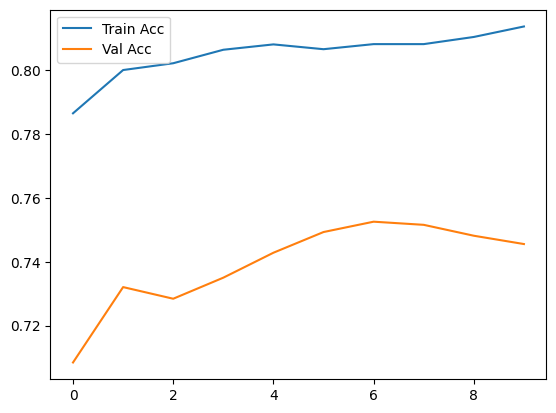

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Image size (VGG16 minimum input size is 32x32, so 50x50 works fine)
IMG_SIZE = 50
BATCH_SIZE = 32

# Data augmentation + validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load VGG16 base model (without top dense layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base to avoid destroying pretrained features

# Build model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, lr_scheduler]
)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


## Model Version 2: VGG16 with Imagenet weights
top 4 layers of base model trainable </br>
train -- 86% accuracy and validation -- 75%

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

import tensorflow as tf

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)


# Bigger image size (VGG16 was trained on 224x224)
IMG_SIZE = 64   # you can push to 224 if GPU memory allows
BATCH_SIZE = 16

# Data augmentation + validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze for now

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),   # better than Flatten
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Training Stage 1
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)


Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.
Epoch 1/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 106s 24ms/step - accuracy: 0.7962 - loss: 0.4533 - val_accuracy: 0.7340 - val_loss: 0.5646 - learning_rate: 0.0010
Epoch 2/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - accuracy: 0.8112 - loss: 0.4273 - val_accuracy: 0.7229 - val_loss: 0.5822 - learning_rate: 0.0010
Epoch 3/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - accuracy: 0.8115 - loss: 0.4225 - val_accuracy: 0.7349 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 112s 26ms/step - accuracy: 0.8186 - loss: 0.4109 - val_accuracy: 0.7404 - val_loss: 0.5473 - learning_rate: 5.0000e-04
Epoch 5/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 122s 28ms/step - accuracy: 0.8196 - loss: 0.4090 - val_accuracy: 0.7393 - val_loss: 0.5531 - learning_rate: 5.0000e-04
Epoch 6/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 126s 29ms/step - accuracy: 0.8219 - loss: 0.4081 - val_accuracy: 0.7407 - val_l

In [5]:
# Unfreeze last conv block
base_model.trainable = True
for layer in base_model.layers[:-4]:  # keep earlier layers frozen
    layer.trainable = False

# Recompile with smaller LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 325s 74ms/step - accuracy: 0.8287 - loss: 0.3947 - val_accuracy: 0.7330 - val_loss: 0.5577 - learning_rate: 1.0000e-05
Epoch 2/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 316s 73ms/step - accuracy: 0.8405 - loss: 0.3711 - val_accuracy: 0.7481 - val_loss: 0.5476 - learning_rate: 1.0000e-05
Epoch 3/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 317s 73ms/step - accuracy: 0.8500 - loss: 0.3519 - val_accuracy: 0.7558 - val_loss: 0.5371 - learning_rate: 5.0000e-06
Epoch 4/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 319s 74ms/step - accuracy: 0.8511 - loss: 0.3450 - val_accuracy: 0.7709 - val_loss: 0.5194 - learning_rate: 5.0000e-06
Epoch 5/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 291s 67ms/step - accuracy: 0.8544 - loss: 0.3400 - val_accuracy: 0.7609 - val_loss: 0.5354 - learning_rate: 5.0000e-06
Epoch 6/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 317s 73ms/step - accuracy: 0.8573 - loss: 0.3340 - val_accuracy: 0.7566 - val_loss: 0.5252 - learning_rate: 5.0000e-06
Epoch 7/10
4324/4324 ━━━━━━━━━━━━━

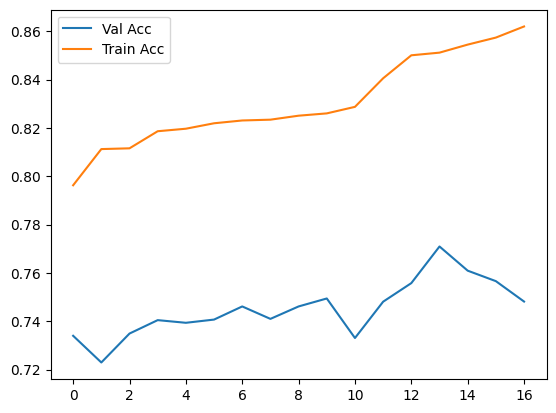

In [6]:
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label="Val Acc")
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label="Train Acc")
plt.legend()
plt.show()


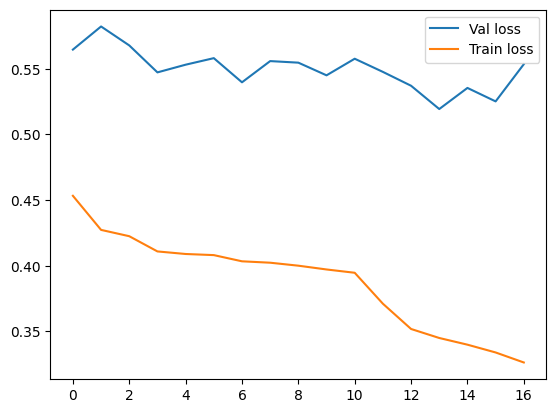

In [7]:
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'], label="Val loss")
plt.plot(history.history['loss'] + history_finetune.history['loss'], label="Train loss")
plt.legend()
plt.show()


## Model version 3: EfficientNetB0
Training from scratch

Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 4,335,741 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10


/home/subarna/anaconda3/envs/breast_cancer/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-14 10:29:51.283868: I external/local_xla/xla/service/service.cc:163] XLA service 0x706db4001c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-14 10:29:51.283888: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A500 Laptop GPU, Compute Capability 8.6
2025-09-14 10:29:51.719734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-14 10:29:53.890818: I external/local_xla/xla/stream_ex

4232/4324 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7781 - loss: 0.5100

2025-09-14 10:32:52.609192: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:32:52.739206: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:32:53.389343: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:32:53.525050: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:32:54.065926: E external/local_xla/xla/stream_

4323/4324 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7786 - loss: 0.5089

/home/subarna/anaconda3/envs/breast_cancer/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-14 10:33:44.706704: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:33:44.836999: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:33:44.966486: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured t

4324/4324 ━━━━━━━━━━━━━━━━━━━━ 249s 48ms/step - accuracy: 0.8018 - loss: 0.4597 - val_accuracy: 0.7937 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 2/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 169s 39ms/step - accuracy: 0.8387 - loss: 0.3885 - val_accuracy: 0.6609 - val_loss: 0.8189 - learning_rate: 0.0010
Epoch 3/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 168s 39ms/step - accuracy: 0.8482 - loss: 0.3667 - val_accuracy: 0.7970 - val_loss: 0.4970 - learning_rate: 0.0010
Epoch 4/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 169s 39ms/step - accuracy: 0.8604 - loss: 0.3374 - val_accuracy: 0.7488 - val_loss: 0.5354 - learning_rate: 5.0000e-04


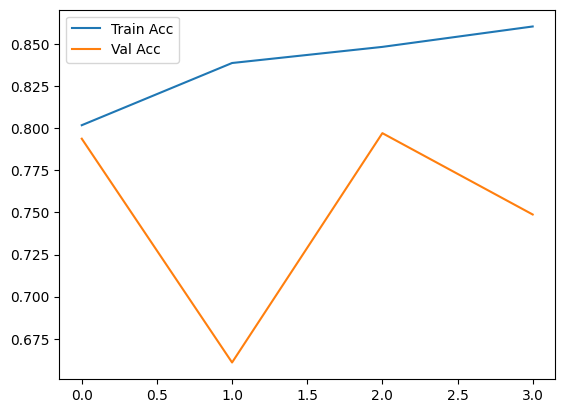

In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf

# ---------------------------
# Settings
# ---------------------------
IMG_SIZE = 96
BATCH_SIZE = 16
EPOCHS = 10

# ---------------------------
# Data
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="rgb",  # your images are RGB
    subset='training'
)

val_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="rgb",
    subset='validation'
)

# ---------------------------
# EfficientNetB0 WITHOUT pretrained weights
# ---------------------------
base_model = EfficientNetB0(
    weights=None,                   # <-- No ImageNet weights
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = True  # all layers trainable from scratch

# ---------------------------
# Build model
# ---------------------------
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ---------------------------
# Callbacks
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ---------------------------
# Train model
# ---------------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

# ---------------------------
# Plot accuracy
# ---------------------------
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


## Model version 4: Training with EfficientNetB3 using the precalculated weights

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = 96
BATCH_SIZE = 16

# Data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="rgb",
    subset='training'
)

val_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="rgb",
    subset='validation'
)

# EfficientNetB3 base
base = EfficientNetB3(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Load official notop weights
weights_url = "https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5"
weights_path = tf.keras.utils.get_file("efficientnetb3_notop.h5", origin=weights_url, cache_subdir="models")
base.load_weights(weights_path)

base.trainable = False  # freeze initially

# Model
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = 96
BATCH_SIZE = 16

# Data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="rgb",
    subset='training'
)

val_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="rgb",
    subset='validation'
)

# EfficientNetB3 base
base = EfficientNetB3(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Load official notop weights
weights_url = "https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5"
weights_path = tf.keras.utils.get_file("efficientnetb3_notop.h5", origin=weights_url, cache_subdir="models")
base.load_weights(weights_path)

base.trainable = False  # freeze initially

# Model
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)


Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/10


2025-09-14 10:46:47.900052: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:46:48.031843: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:46:48.677586: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:46:48.817161: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:46:49.301045: E external/local_xla/xla/stream_

2257/4324 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.5521 - loss: 0.6972

2025-09-14 10:47:46.345951: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:47:46.479335: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:47:46.613126: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:47:47.264225: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:47:47.404379: E external/local_xla/xla/stream_

4322/4324 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5526 - loss: 0.6935

2025-09-14 10:49:05.041230: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:49:05.173387: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:49:05.828313: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:49:05.968710: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-14 10:49:06.466167: E external/local_xla/xla/stream_

4324/4324 ━━━━━━━━━━━━━━━━━━━━ 154s 31ms/step - accuracy: 0.5534 - loss: 0.6889 - val_accuracy: 0.5551 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 2/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 104s 24ms/step - accuracy: 0.5551 - loss: 0.6872 - val_accuracy: 0.5551 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 3/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 104s 24ms/step - accuracy: 0.5551 - loss: 0.6871 - val_accuracy: 0.5551 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 4/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 106s 24ms/step - accuracy: 0.5551 - loss: 0.6871 - val_accuracy: 0.5551 - val_loss: 0.6871 - learning_rate: 5.0000e-04


## Model v5: VGG16 with imagenet multiple layers unfrezzed

Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.
Epoch 1/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 106s 24ms/step - accuracy: 0.7981 - loss: 0.4511 - val_accuracy: 0.7353 - val_loss: 0.5821 - learning_rate: 0.0010
Epoch 2/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - accuracy: 0.8105 - loss: 0.4286 - val_accuracy: 0.7329 - val_loss: 0.5803 - learning_rate: 0.0010
Epoch 3/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 103s 24ms/step - accuracy: 0.8130 - loss: 0.4215 - val_accuracy: 0.7344 - val_loss: 0.5795 - learning_rate: 0.0010
Epoch 4/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 103s 24ms/step - accuracy: 0.8155 - loss: 0.4193 - val_accuracy: 0.7481 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 5/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 103s 24ms/step - accuracy: 0.8165 - loss: 0.4190 - val_accuracy: 0.7418 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 6/10
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 103s 24ms/step - accuracy: 0.8169 - loss: 0.4142 - val_accuracy: 0.7316 - val_loss: 0.5

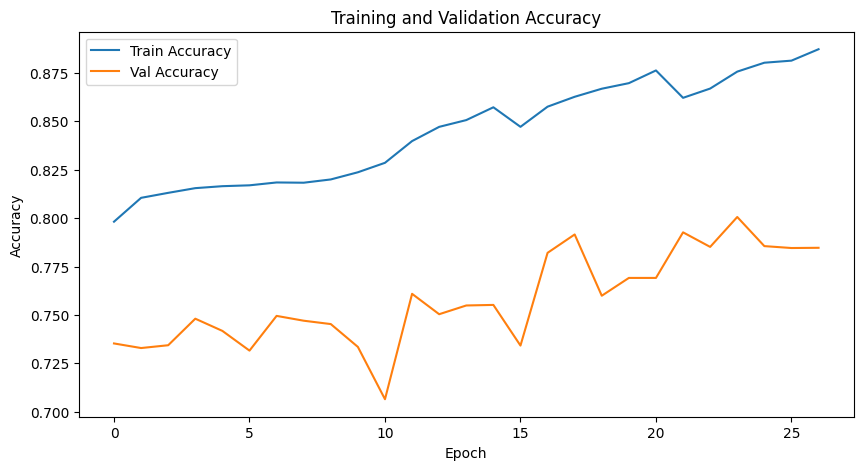

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# ---------------------------
# Parameters
# ---------------------------
IMG_SIZE = 64
BATCH_SIZE = 16
EPOCHS_STAGE1 = 10
EPOCHS_FINE = 10

# ---------------------------
# Data Augmentation
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# ---------------------------
# Base Model
# ---------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze for initial training

# ---------------------------
# Build Model
# ---------------------------
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------------------------
# Callbacks
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ---------------------------
# Stage 1: Train top layers only
# ---------------------------
history_stage1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop, lr_scheduler]
)

# ---------------------------
# Fine-Tuning Function
# ---------------------------
def fine_tune_model(model, base_model, blocks_to_unfreeze=1, lr=1e-5, epochs=EPOCHS_FINE):
    """
    Fine-tune last 'blocks_to_unfreeze' convolutional blocks of VGG16.
    """
    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 'blocks_to_unfreeze' blocks
    blocks = ['block5', 'block4', 'block3', 'block2', 'block1']
    for block_name in blocks[:blocks_to_unfreeze]:
        for layer in base_model.layers:
            if block_name in layer.name:
                layer.trainable = True

    # Compile with small learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stop, lr_scheduler]
    )
    return history

# ---------------------------
# Stage 2: Fine-tune last conv block (block5)
# ---------------------------
history_block5 = fine_tune_model(model, base_model, blocks_to_unfreeze=1, lr=1e-5)

# ---------------------------
# Stage 3: Fine-tune last 2 conv blocks (block4+5)
# ---------------------------
history_block4_5 = fine_tune_model(model, base_model, blocks_to_unfreeze=2, lr=1e-5)

# ---------------------------
# Stage 4: Fine-tune last 3 conv blocks (block3+4+5)
# ---------------------------
history_block3_4_5 = fine_tune_model(model, base_model, blocks_to_unfreeze=3, lr=1e-5)

# ---------------------------
# Plot combined accuracy
# ---------------------------
acc = history_stage1.history['accuracy'] + history_block5.history['accuracy'] + \
      history_block4_5.history['accuracy'] + history_block3_4_5.history['accuracy']
val_acc = history_stage1.history['val_accuracy'] + history_block5.history['val_accuracy'] + \
          history_block4_5.history['val_accuracy'] + history_block3_4_5.history['val_accuracy']

plt.figure(figsize=(10,5))
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


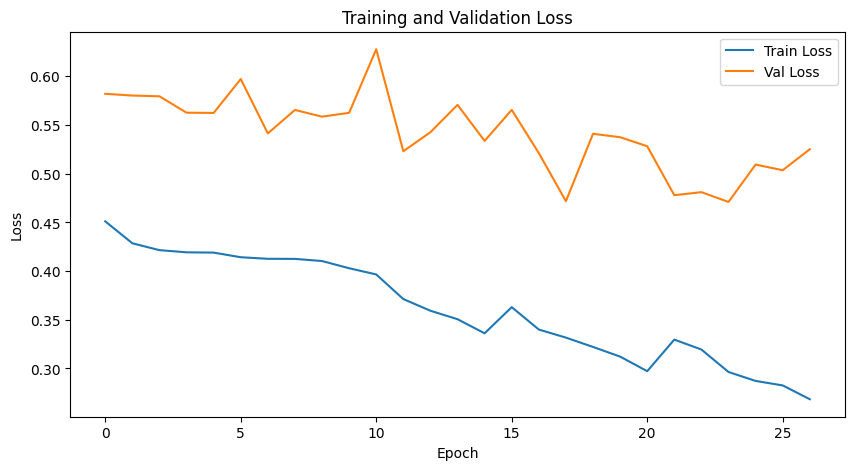

In [6]:
# ---------------------------
# Plot combined loss
# ---------------------------
loss = history_stage1.history['loss'] + history_block5.history['loss'] + \
       history_block4_5.history['loss'] + history_block3_4_5.history['loss']
val_loss = history_stage1.history['val_loss'] + history_block5.history['val_loss'] + \
           history_block4_5.history['val_loss'] + history_block3_4_5.history['val_loss']

plt.figure(figsize=(10,5))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step


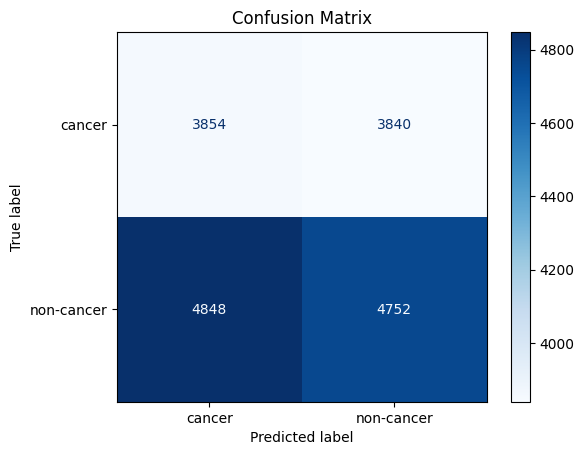


Classification Report:
              precision    recall  f1-score   support

      cancer       0.44      0.50      0.47      7694
  non-cancer       0.55      0.49      0.52      9600

    accuracy                           0.50     17294
   macro avg       0.50      0.50      0.50     17294
weighted avg       0.50      0.50      0.50     17294



In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
val_data.reset()  # important to reset before predicting
y_pred_probs = model.predict(val_data, verbose=1)
y_pred = (y_pred_probs > 0.5).astype("int32").ravel()

# True labels
y_true = val_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_data.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))


In [10]:
model.save("cancer_vgg16_model.keras")

Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.
Epoch 1/20


/home/subarna/anaconda3/envs/breast_cancer/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4324/4324 ━━━━━━━━━━━━━━━━━━━━ 524s 120ms/step - accuracy: 0.8438 - loss: 0.3677 - val_accuracy: 0.7707 - val_loss: 0.5131 - learning_rate: 1.0000e-05
Epoch 2/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 530s 123ms/step - accuracy: 0.8621 - loss: 0.3290 - val_accuracy: 0.7803 - val_loss: 0.4692 - learning_rate: 1.0000e-05
Epoch 3/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 525s 122ms/step - accuracy: 0.8677 - loss: 0.3160 - val_accuracy: 0.7910 - val_loss: 0.4671 - learning_rate: 1.0000e-05
Epoch 4/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 533s 123ms/step - accuracy: 0.8726 - loss: 0.3042 - val_accuracy: 0.7925 - val_loss: 0.4783 - learning_rate: 1.0000e-05
Epoch 5/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 558s 129ms/step - accuracy: 0.8763 - loss: 0.2962 - val_accuracy: 0.8026 - val_loss: 0.4521 - learning_rate: 1.0000e-05
Epoch 6/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 559s 129ms/step - accuracy: 0.8802 - loss: 0.2878 - val_accuracy: 0.7915 - val_loss: 0.4643 - learning_rate: 1.0000e-05
Epoch 7/20
4324/4324 ━━━━━━━━━━━━━━━━━━

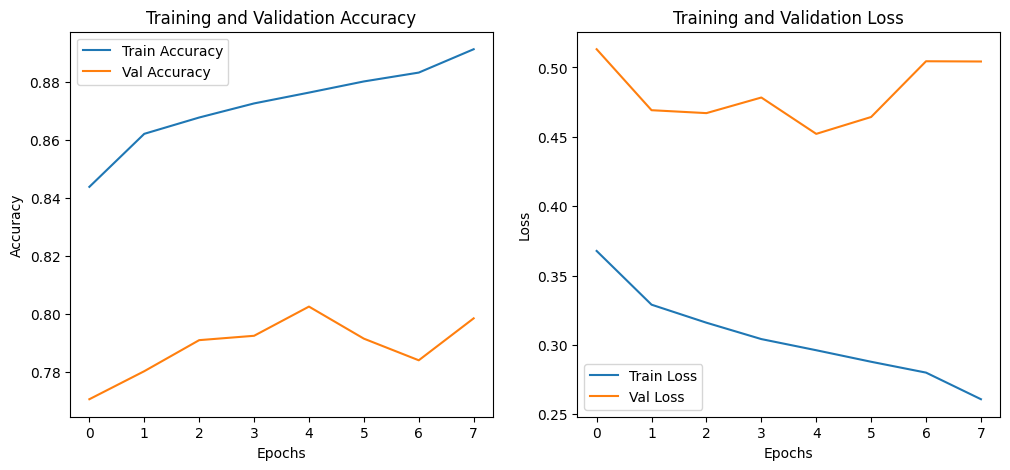

1081/1081 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step


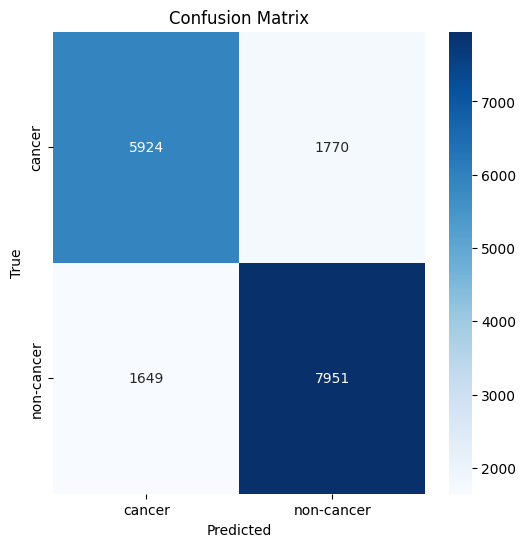

Classification Report:
               precision    recall  f1-score   support

      cancer       0.78      0.77      0.78      7694
  non-cancer       0.82      0.83      0.82      9600

    accuracy                           0.80     17294
   macro avg       0.80      0.80      0.80     17294
weighted avg       0.80      0.80      0.80     17294



In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ---------------------------
# Parameters
# ---------------------------
IMG_SIZE = 64
BATCH_SIZE = 16
EPOCHS = 20   # since all layers are trainable, might need more epochs

# ---------------------------
# Data Augmentation
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    "smaller_datset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# ---------------------------
# Base Model (all layers trainable)
# ---------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True   # <-- train ALL layers

# ---------------------------
# Build Model
# ---------------------------
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR to avoid destroying pre-trained weights
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# Callbacks
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ---------------------------
# Training
# ---------------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

# ---------------------------
# Plot Accuracy & Loss
# ---------------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ---------------------------
# Confusion Matrix + Classification Report
# ---------------------------
y_pred = model.predict(val_data, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(val_data.classes, y_pred_classes)
cr = classification_report(val_data.classes, y_pred_classes, target_names=val_data.class_indices.keys())

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", cr)


In [13]:
model.save("cancer_detection_vgg16_fully trained.keras")

Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/20


/home/subarna/anaconda3/envs/breast_cancer/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4324/4324 ━━━━━━━━━━━━━━━━━━━━ 355s 63ms/step - accuracy: 0.8398 - loss: 0.3829 - val_accuracy: 0.8139 - val_loss: 0.4575 - learning_rate: 1.0000e-04
Epoch 2/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 192s 44ms/step - accuracy: 0.8653 - loss: 0.3303 - val_accuracy: 0.8083 - val_loss: 0.4431 - learning_rate: 1.0000e-04
Epoch 3/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 189s 44ms/step - accuracy: 0.8708 - loss: 0.3149 - val_accuracy: 0.7586 - val_loss: 0.5419 - learning_rate: 1.0000e-04
Epoch 4/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 188s 44ms/step - accuracy: 0.8743 - loss: 0.3064 - val_accuracy: 0.8199 - val_loss: 0.4161 - learning_rate: 1.0000e-04
Epoch 5/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 187s 43ms/step - accuracy: 0.8788 - loss: 0.2974 - val_accuracy: 0.8079 - val_loss: 0.5806 - learning_rate: 1.0000e-04
Epoch 6/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 190s 44ms/step - accuracy: 0.8800 - loss: 0.2926 - val_accuracy: 0.7946 - val_loss: 0.4648 - learning_rate: 1.0000e-04
Epoch 7/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 193

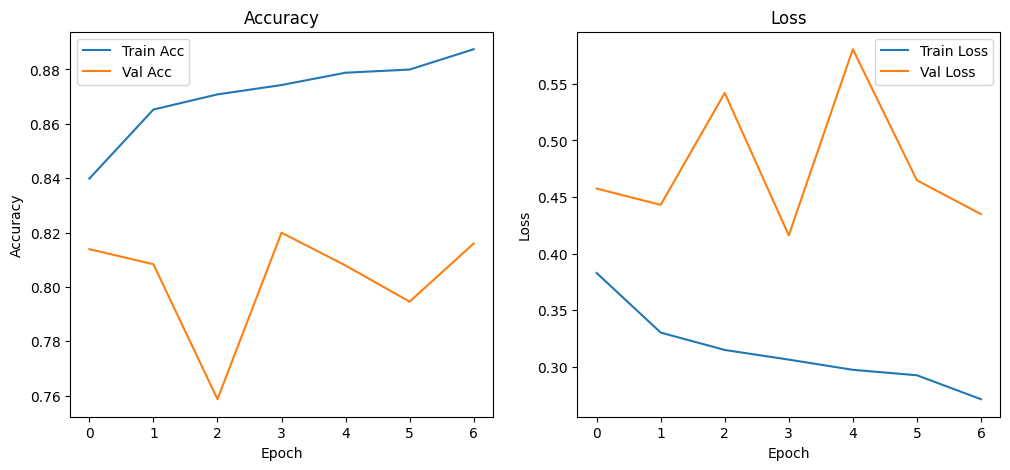

1081/1081 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step
Confusion Matrix:
[[6415 1279]
 [1873 7727]]

Classification Report:
              precision    recall  f1-score   support

      cancer       0.77      0.83      0.80      7694
  non-cancer       0.86      0.80      0.83      9600

    accuracy                           0.82     17294
   macro avg       0.82      0.82      0.82     17294
weighted avg       0.82      0.82      0.82     17294



In [16]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ---------------------------
# Parameters
# ---------------------------
IMG_SIZE = 64
BATCH_SIZE = 16
EPOCHS = 20
DATA_DIR = "smaller_datset"

# ---------------------------
# Data Augmentation
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# ---------------------------
# Model (DenseNet121)
# ---------------------------
base_model = DenseNet121(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = True  # all layers trainable

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# Callbacks
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ---------------------------
# Train the model
# ---------------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

# ---------------------------
# Plot Accuracy and Loss
# ---------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ---------------------------
# Confusion Matrix & Classification Report
# ---------------------------
val_steps = val_data.n // val_data.batch_size + 1
val_preds = model.predict(val_data, steps=val_steps)
val_preds_classes = (val_preds > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(val_data.classes, val_preds_classes[:len(val_data.classes)]))

print("\nClassification Report:")
print(classification_report(val_data.classes, val_preds_classes[:len(val_data.classes)], target_names=list(train_data.class_indices.keys())))

# ---------------------------
# Save Model
# ---------------------------
model.save("breast_cancer_densenet121.keras")


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


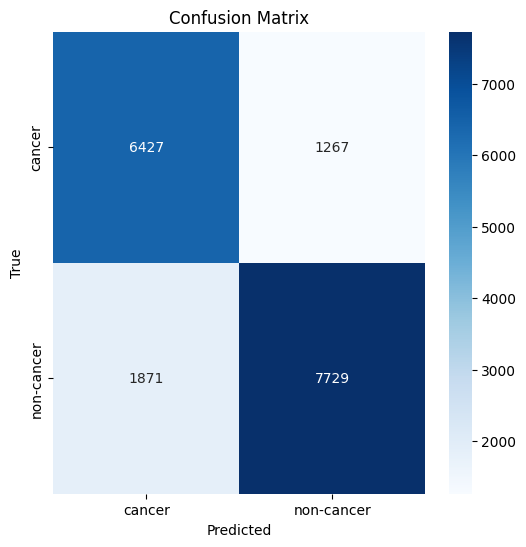

Classification Report:
               precision    recall  f1-score   support

      cancer       0.77      0.84      0.80      7694
  non-cancer       0.86      0.81      0.83      9600

    accuracy                           0.82     17294
   macro avg       0.82      0.82      0.82     17294
weighted avg       0.82      0.82      0.82     17294



In [18]:
y_pred = model.predict(val_data, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(val_data.classes, y_pred_classes)
cr = classification_report(val_data.classes, y_pred_classes, target_names=val_data.class_indices.keys())

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", cr)

Found 69183 images belonging to 2 classes.
Found 17294 images belonging to 2 classes.
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/20


/home/subarna/anaconda3/envs/breast_cancer/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-14 16:43:09.625046: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3389/4324 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - accuracy: 0.8203 - loss: 0.4295

2025-09-14 16:47:37.089726: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_49294', 12 bytes spill stores, 12 bytes spill loads

2025-09-14 16:47:43.666732: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4324/4324 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8252 - loss: 0.4185

2025-09-14 16:50:02.763758: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4571', 12 bytes spill stores, 12 bytes spill loads



4324/4324 ━━━━━━━━━━━━━━━━━━━━ 467s 83ms/step - accuracy: 0.8445 - loss: 0.3742 - val_accuracy: 0.8022 - val_loss: 0.4598 - learning_rate: 1.0000e-04
Epoch 2/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - accuracy: 0.8641 - loss: 0.3310 - val_accuracy: 0.8108 - val_loss: 0.4440 - learning_rate: 1.0000e-04
Epoch 3/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 267s 62ms/step - accuracy: 0.8707 - loss: 0.3160 - val_accuracy: 0.8223 - val_loss: 0.4183 - learning_rate: 1.0000e-04
Epoch 4/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 268s 62ms/step - accuracy: 0.8737 - loss: 0.3086 - val_accuracy: 0.7903 - val_loss: 0.4834 - learning_rate: 1.0000e-04
Epoch 5/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 272s 63ms/step - accuracy: 0.8771 - loss: 0.3009 - val_accuracy: 0.8401 - val_loss: 0.4249 - learning_rate: 1.0000e-04
Epoch 6/20
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 272s 63ms/step - accuracy: 0.8849 - loss: 0.2794 - val_accuracy: 0.8320 - val_loss: 0.4295 - learning_rate: 5.0000e-05


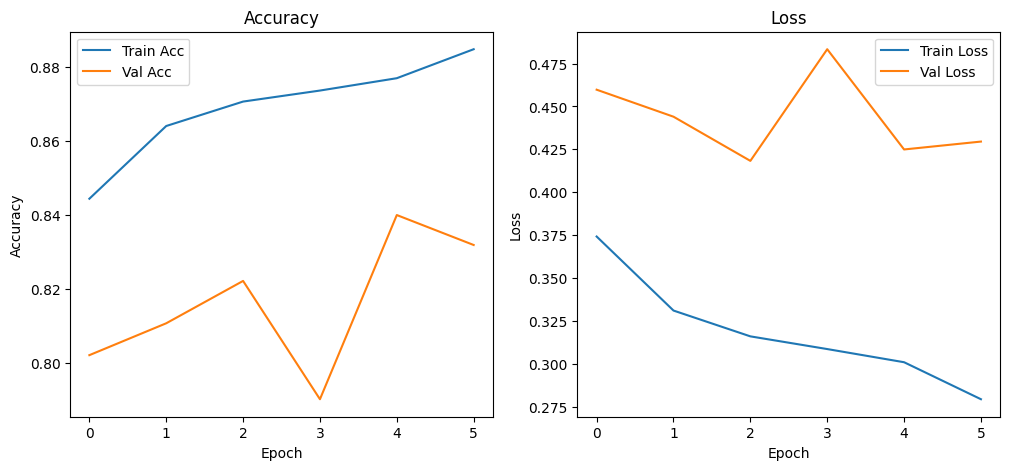

1081/1081 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step


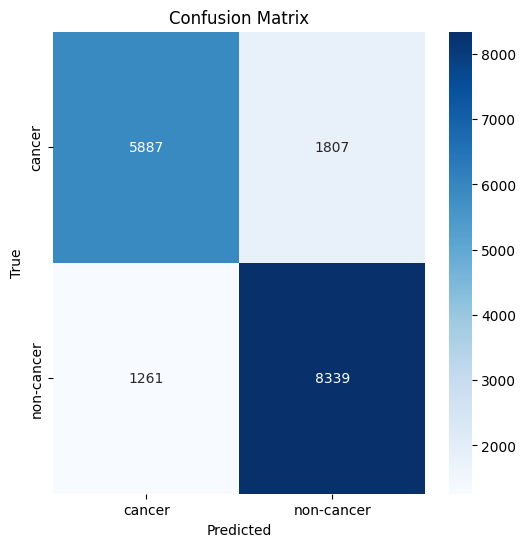

Classification Report:
               precision    recall  f1-score   support

      cancer       0.82      0.77      0.79      7694
  non-cancer       0.82      0.87      0.84      9600

    accuracy                           0.82     17294
   macro avg       0.82      0.82      0.82     17294
weighted avg       0.82      0.82      0.82     17294



In [19]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ---------------------------
# Parameters
# ---------------------------
IMG_SIZE = 64
BATCH_SIZE = 16
EPOCHS = 20
DATA_DIR = "smaller_datset"

# ---------------------------
# Data Augmentation
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# ---------------------------
# Model (DenseNet121)
# ---------------------------
base_model = DenseNet169(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = True  # all layers trainable

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# Callbacks
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ---------------------------
# Train the model
# ---------------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

# ---------------------------
# Plot Accuracy and Loss
# ---------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ---------------------------
# Confusion Matrix & Classification Report
# ---------------------------
y_pred = model.predict(val_data, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(val_data.classes, y_pred_classes)
cr = classification_report(val_data.classes, y_pred_classes, target_names=val_data.class_indices.keys())

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", cr)
# ---------------------------
# Save Model
# ---------------------------
model.save("breast_cancer_densenet169.keras")
